# Market Making with Alpha - APT

## Overview

Continuing from [Market Making with Alpha - Basis](https://hftbacktest.readthedocs.io/en/latest/tutorials/Market%20Making%20with%20Alpha%20-%20Basis.html), this example demonstrates market making based on [Arbitrage Pricing Theory](https://en.wikipedia.org/wiki/Arbitrage_pricing_theory).



<div class="alert alert-info">
    
**Note:** This example is for educational purposes only and demonstrates effective strategies for high-frequency market-making schemes. All backtests are based on a 0.005% rebate, the highest market maker rebate available on Binance Futures. See <a href="https://www.binance.com/en/support/announcement/binance-updates-usd%E2%93%A2-margined-futures-liquidity-provider-program-2024-06-03-fefc6aa25e0947e2bf745c1c56bea13e">Binance Upgrades USDⓢ-Margined Futures Liquidity Provider Program</a> for more details.
    
</div>

In [1]:
import datetime
import os

import numpy as np

from numba import njit, uint64
from numba.typed import Dict

from hftbacktest import (
    BacktestAsset,
    ROIVectorMarketDepthBacktest,
    GTX,
    LIMIT,
    BUY,
    SELL,
    BUY_EVENT,
    SELL_EVENT,
    Recorder
)
from hftbacktest.stats import LinearAssetRecord

import polars as pl
import statsmodels.api as sm
from matplotlib import pyplot

def load_bookticker(file):
    return pl.read_csv(file, schema={
        'exchange': pl.String,
        'symbol': pl.String,
        'timestamp': pl.Int64,
        'local_timestamp': pl.Int64,
        'ask_amount': pl.Float64,
        'ask_price': pl.Float64,
        'bid_price': pl.Float64,
        'bid_amount': pl.Float64
    }).with_columns(
        pl.col('local_timestamp').cast(pl.Datetime),
        mid_price = (.5 * (pl.col('bid_price') + pl.col('ask_price'))),
    ).select(['local_timestamp', 'mid_price'])

def prepare_px_return(spot_file, futures_file, sampling_interval, rolling_window, shift):
    spot = load_bookticker(spot_file)
    futures = load_bookticker(futures_file)

    # Resamples prices to calculate returns.
    spot_rs = spot.group_by_dynamic(
        index_column='local_timestamp',
        every=sampling_interval
    ).agg(
        pl.col('mid_price').last()
    ).upsample(
        time_column='local_timestamp',
        every=sampling_interval
    ).select(pl.all().forward_fill())
    
    futures_rs = futures.group_by_dynamic(
        index_column='local_timestamp',
        every=sampling_interval
    ).agg(
        pl.col('mid_price').last(),
    ).upsample(
        time_column='local_timestamp',
        every=sampling_interval
    ).select(pl.all().forward_fill())

    # When computing returns, if one chooses the past price at a specific time point, 
    # it may result in selecting an noiser value, leading to a noisier return calculation.
    # 
    # To mitigate this issue, the average price over a past period is used. 
    # For example, to compute 5-minute returns, the average price over a 5-minute window centered around 5 minutes ago is used.
    
    return spot_rs.join(
        futures_rs,
        left_on='local_timestamp',
        right_on='local_timestamp',
        how='full'
    ).with_columns(
        futures_px=pl.col('mid_price_right').forward_fill(),
        spot_px=pl.col('mid_price').forward_fill()
    ).with_columns(
        futures_past_px=pl.col('futures_px').rolling_mean(window_size=rolling_window).shift(shift),
        spot_past_px=pl.col('spot_px').rolling_mean(window_size=rolling_window).shift(shift)
    ).with_columns(
        local_timestamp=pl.col('local_timestamp').dt.timestamp('ns'),
        spot_return=pl.col('spot_px') / pl.col('spot_past_px') - 1,
        futures_return=pl.col('futures_px') / pl.col('futures_past_px') - 1,
    ).select(
        ['local_timestamp', 'spot_return', 'spot_past_px', 'futures_return', 'futures_past_px']
    )

In [2]:
start_date = datetime.datetime.strptime('20240901', '%Y%m%d')
end_date = datetime.datetime.strptime('20241031', '%Y%m%d')

In [3]:
data = []
date = start_date
while date <= end_date:
    data.append(prepare_px_return(
        f'spot/book_ticker/BTCUSDT/BTCUSDT_{date.strftime("%Y%m%d")}.csv.gz',
        f'usdm/book_ticker/BTCUSDT/BTCUSDT_{date.strftime("%Y%m%d")}.csv.gz',
        '100ms',
        3000, # 5-minute
        1500 # 2.5-minute, the average price over a 5-minute window centered around 5 minutes ago
    ).to_numpy())
    date += datetime.timedelta(days=1)
precompute_data = np.concatenate(data, axis=0)

In [4]:
np.savez_compressed("precompute_px_return_BTCUSDT_5m", data=precompute_data)

In [5]:
precompute_data = np.load("precompute_px_return_BTCUSDT_5m.npz")["data"]

In [6]:
spot_returns = precompute_data[:, 1]
futures_returns = precompute_data[:, 3]
m = np.isfinite(spot_returns) & np.isfinite(futures_returns)

spot_returns = spot_returns[m]
futures_returns = futures_returns[m]

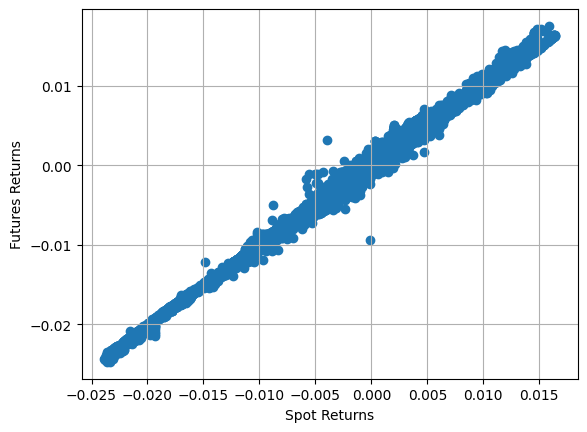

In [7]:
pyplot.scatter(spot_returns, futures_returns)
pyplot.xlabel('Spot Returns')
pyplot.ylabel('Futures Returns')
pyplot.grid()

Under Arbitrage Pricing Theory, the relationship between futures return and spot return can be expressed as:

$Return_{futures} = \alpha + \beta_{spot} * Return_{spot}$

Under the assumption that $\beta_{spot}$ = 1 and $\alpha$ = 0, the futures return should be equal to the spot return. This also implies that any residual movement is mean-reverting to zero, similar to what is shown in the basis example.

**Extending the Model**

Beyond this basic relationship, additional return-contributing factors can be incorporated. For instance, returns from other exchanges’ Bitcoin markets, such as:

* CME Bitcoin futures, Bybit's BTC futures and other platforms's BTC futures
* Bitcoin ETFs
* Spot prices from Coinbase, Kraken, and other platforms

Moreover, this is not limited to the same asset. Other cryptocurrencies, traditional assets, and macroeconomic indices can be considered, such as:

* Ethereum (ETH)
* S&P 500
* Dollar Index

Additionally, market microstructure factors, such as order book imbalance, can further enhance the model, as demonstrated in [our other example](https://hftbacktest.readthedocs.io/en/latest/tutorials/Market%20Making%20with%20Alpha%20-%20Order%20Book%20Imbalance.html).

This broader framework allows for a more comprehensive understanding of price movements and their underlying drivers.

In [10]:
@njit
def apt_mm(
    hbt,
    stat,
    half_spread,
    skew,
    precompute_data,
    interval,
    order_qty_dollar,
    max_position_dollar,
    grid_num,
    grid_interval_,
    roi_lb,
    roi_ub
):
    asset_no = 0

    tick_size = hbt.depth(0).tick_size
    lot_size = hbt.depth(0).lot_size
    
    roi_lb_tick = int(round(roi_lb / tick_size))
    roi_ub_tick = int(round(roi_ub / tick_size))

    data_i = 0
    spot_return = np.nan
    futures_past_px = np.nan
    
    while hbt.elapse(interval) == 0:
        hbt.clear_inactive_orders(asset_no)
        
        depth = hbt.depth(asset_no)
        position = hbt.position(asset_no)
        orders = hbt.orders(asset_no)

        best_bid = depth.best_bid
        best_ask = depth.best_ask
        
        while data_i < len(precompute_data):
            if precompute_data[data_i, 0] > hbt.current_timestamp:
                if data_i > 0:
                    spot_return = precompute_data[data_i - 1, 1]
                    futures_past_px = precompute_data[data_i - 1, 4]
                break
            data_i += 1

        #--------------------------------------------------------
        # Computes bid price and ask price.

        mid_price = (best_bid + best_ask) / 2.0
        order_qty = max(round((order_qty_dollar / mid_price) / lot_size) * lot_size, lot_size)
        
        normalized_position = position / order_qty
        
        relative_bid_depth = half_spread + skew * normalized_position
        relative_ask_depth = half_spread - skew * normalized_position
        beta = 1
        alpha = 0
        return_ = beta * spot_return + alpha
        fair_px = (1 + return_) * futures_past_px

        bid_price = min(fair_px * (1.0 - relative_bid_depth), best_bid)
        ask_price = max(fair_px * (1.0 + relative_ask_depth), best_ask)
        
        bid_price = np.floor(bid_price / tick_size) * tick_size
        ask_price = np.ceil(ask_price / tick_size) * tick_size

        grid_interval = max(tick_size, np.round(grid_interval_ * fair_px / tick_size) * tick_size)
        
        # Aligns the prices to the grid.
        bid_price = np.floor(bid_price / grid_interval) * grid_interval
        ask_price = np.ceil(ask_price / grid_interval) * grid_interval
        
        #--------------------------------------------------------
        # Updates quotes.
        
        # Creates a new grid for buy orders.
        new_bid_orders = Dict.empty(np.uint64, np.float64)
        if position * mid_price < max_position_dollar and np.isfinite(bid_price):
            for i in range(grid_num):
                bid_price_tick = round(bid_price / tick_size)
                
                # order price in tick is used as order id.
                new_bid_orders[uint64(bid_price_tick)] = bid_price
                
                bid_price -= grid_interval

        # Creates a new grid for sell orders.
        new_ask_orders = Dict.empty(np.uint64, np.float64)
        if position * mid_price > -max_position_dollar and np.isfinite(ask_price):
            for i in range(grid_num):
                ask_price_tick = round(ask_price / tick_size)
                
                # order price in tick is used as order id.
                new_ask_orders[uint64(ask_price_tick)] = ask_price

                ask_price += grid_interval
                
        order_values = orders.values();
        while order_values.has_next():
            order = order_values.get()
            # Cancels if a working order is not in the new grid.
            if order.cancellable:
                if (
                    (order.side == BUY and order.order_id not in new_bid_orders)
                    or (order.side == SELL and order.order_id not in new_ask_orders)
                ):
                    hbt.cancel(asset_no, order.order_id, False)
                    
        for order_id, order_price in new_bid_orders.items():
            # Posts a new buy order if there is no working order at the price on the new grid.
            if order_id not in orders:
                hbt.submit_buy_order(asset_no, order_id, order_price, order_qty, GTX, LIMIT, False)
                
        for order_id, order_price in new_ask_orders.items():
            # Posts a new sell order if there is no working order at the price on the new grid.
            if order_id not in orders:
                hbt.submit_sell_order(asset_no, order_id, order_price, order_qty, GTX, LIMIT, False)
        
        # Records the current state for stat calculation.
        stat.record(hbt)

In [11]:
%%time

roi_lb = 10000
roi_ub = 90000

latency_data = []
date = start_date
while date <= end_date:
    latency_data.append('latency/order_latency_{}.npz'.format(date.strftime('%Y%m%d')))
    date += datetime.timedelta(days=1)

data = []
date = start_date
while date <= end_date:
    data.append('data2/btcusdt_{}.npz'.format(date.strftime("%Y%m%d")))
    date += datetime.timedelta(days=1)

asset = (
    BacktestAsset()
        .data(data)
        .initial_snapshot('data2/btcusdt_20240831_eod.npz')
        .linear_asset(1.0) 
        .intp_order_latency(latency_data)
        .power_prob_queue_model(3)
        .no_partial_fill_exchange()
        .trading_value_fee_model(-0.00005, 0.0007)
        .tick_size(0.1)
        .lot_size(0.001)
        .roi_lb(roi_lb)    
        .roi_ub(roi_ub)
)

hbt = ROIVectorMarketDepthBacktest([asset])

recorder = Recorder(1, 60_000_000)

half_spread = 0.0003 # a ratio relative to the fair price
skew = half_spread / 20
interval = 100_000_000 # in nanoseconds. 100ms
order_qty_dollar = 50_000
max_position_dollar = order_qty_dollar * 20
grid_num = 1
grid_interval = hbt.depth(0).tick_size

apt_mm(
    hbt,
    recorder.recorder,
    half_spread,
    skew,
    precompute_data,
    interval,
    order_qty_dollar,
    max_position_dollar,
    grid_num,
    grid_interval,
    roi_lb,
    roi_ub
)

hbt.close()

recorder.to_npz('stats/underlying_btcusdt_return_5m.npz')

CPU times: user 1h 2min 18s, sys: 1min 45s, total: 1h 4min 3s
Wall time: 40min 2s


In [12]:
data = np.load('stats/underlying_btcusdt_return_5m.npz')['0']
stats = (
    LinearAssetRecord(data)
        .resample('5m')
        .stats(book_size=2_500_000)
)
stats.summary()

The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTurnover,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-09-01 00:00:00,2024-10-31 23:55:00,3.578158,4.821155,0.025127,0.010283,568.442193,11.368845,2.443528,0.000036,1.0415e6


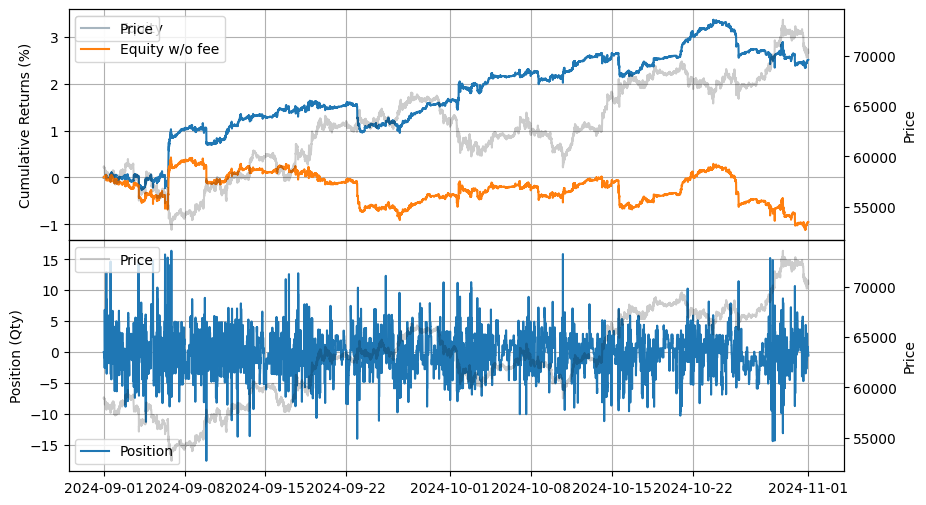

In [13]:
stats.plot()

As demonstrated in the basis example, BTCFDUSD behaves in a similar manner.

In [15]:
data = []
date = start_date
while date <= end_date:
    data.append(prepare_px_return(
        f'spot/book_ticker/BTCFDUSD/BTCFDUSD_{date.strftime("%Y%m%d")}.csv.gz',
        f'usdm/book_ticker/BTCUSDT/BTCUSDT_{date.strftime("%Y%m%d")}.csv.gz',
        '100ms',
        3000, # 5-minute window
        1500 # 2.5-minute, the average price over a 5-minute window centered around 5 minutes ago
    ).to_numpy())
    date += datetime.timedelta(days=1)
precompute_data = np.concatenate(data, axis=0)

In [16]:
np.savez_compressed("precompute_px_return_BTCFDUSD_5m", data=precompute_data)

In [17]:
precompute_data = np.load("precompute_px_return_BTCFDUSD_5m.npz")["data"]

In [18]:
spot_returns = precompute_data[:, 1]
futures_returns = precompute_data[:, 3]
m = np.isfinite(spot_returns) & np.isfinite(futures_returns)

spot_returns = spot_returns[m]
futures_returns = futures_returns[m]

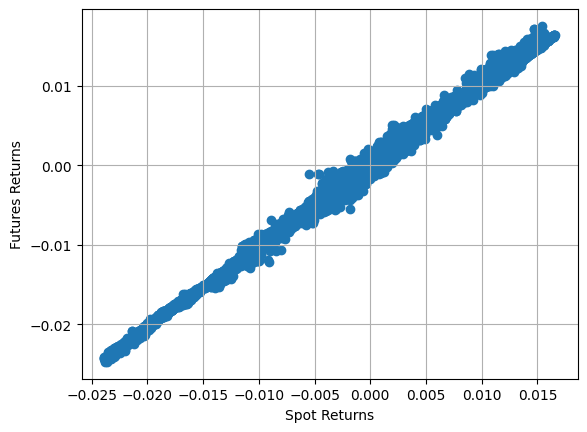

In [19]:
pyplot.scatter(spot_returns, futures_returns)
pyplot.xlabel('Spot Returns')
pyplot.ylabel('Futures Returns')
pyplot.grid()

In [21]:
%%time

roi_lb = 10000
roi_ub = 90000

latency_data = []
date = start_date
while date <= end_date:
    latency_data.append('latency/order_latency_{}.npz'.format(date.strftime('%Y%m%d')))
    date += datetime.timedelta(days=1)

data = []
date = start_date
while date <= end_date:
    data.append('data2/btcusdt_{}.npz'.format(date.strftime("%Y%m%d")))
    date += datetime.timedelta(days=1)

asset = (
    BacktestAsset()
        .data(data)
        .initial_snapshot('data2/btcusdt_20240831_eod.npz')
        .linear_asset(1.0) 
        .intp_order_latency(latency_data)
        .power_prob_queue_model(3)
        .no_partial_fill_exchange()
        .trading_value_fee_model(-0.00005, 0.0007)
        .tick_size(0.1)
        .lot_size(0.001)
        .roi_lb(roi_lb)    
        .roi_ub(roi_ub)
)

hbt = ROIVectorMarketDepthBacktest([asset])

recorder = Recorder(1, 60_000_000)

half_spread = 0.0003 # a ratio relative to the fair price
skew = half_spread / 20
interval = 100_000_000 # in nanoseconds. 100ms
order_qty_dollar = 50_000
max_position_dollar = order_qty_dollar * 20
grid_num = 1
grid_interval = hbt.depth(0).tick_size

apt_mm(
    hbt,
    recorder.recorder,
    half_spread,
    skew,
    precompute_data,
    interval,
    order_qty_dollar,
    max_position_dollar,
    grid_num,
    grid_interval,
    roi_lb,
    roi_ub
)

hbt.close()

recorder.to_npz('stats/underlying_btcfdusd_return_5m.npz')

CPU times: user 1h 4min 56s, sys: 1min 52s, total: 1h 6min 48s
Wall time: 42min 35s


In [22]:
data = np.load('stats/underlying_btcfdusd_return_5m.npz')['0']
stats = (
    LinearAssetRecord(data)
        .resample('5m')
        .stats(book_size=2_500_000)
)
stats.summary()

start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTurnover,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-09-01 00:00:00,2024-10-31 23:55:00,3.125613,4.000555,0.031671,0.020096,504.372972,10.087474,1.575961,0.000051,1.2871e6


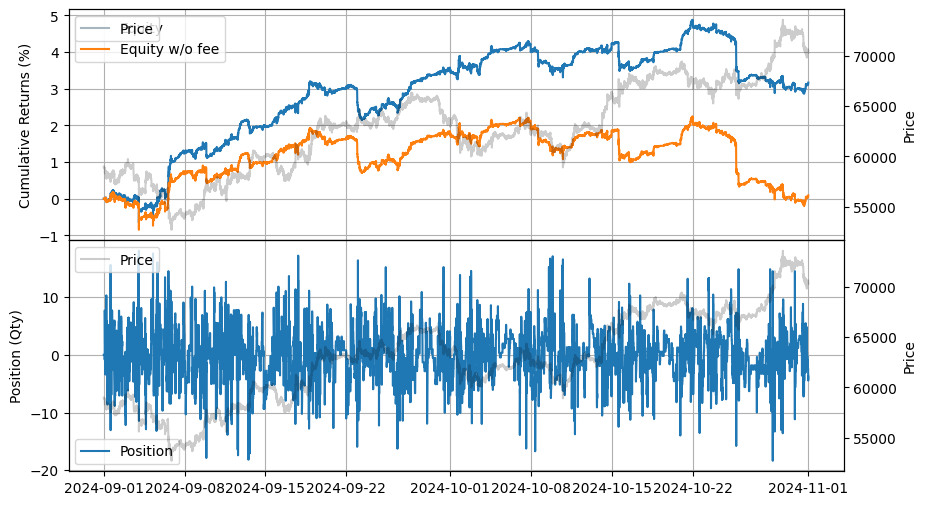

In [23]:
stats.plot()

## Integrating Grid Trading

In [25]:
start_date = datetime.datetime.strptime('20250101', '%Y%m%d')
end_date = datetime.datetime.strptime('20250228', '%Y%m%d')

In [26]:
data = []
date = start_date
while date <= end_date:
    data.append(prepare_px_return(
        f'spot/book_ticker/BTCUSDT/BTCUSDT_{date.strftime("%Y%m%d")}.csv.gz',
        f'usdm/book_ticker/BTCUSDT/BTCUSDT_{date.strftime("%Y%m%d")}.csv.gz',
        '100ms',
        3000, # 5-minute
        1500 # 2.5-minute, the average price over a 5-minute window centered around 5 minutes ago
    ).to_numpy())
    date += datetime.timedelta(days=1)
precompute_data = np.concatenate(data, axis=0)

In [27]:
np.savez_compressed("precompute_px_return_BTCUSDT_5m_2025", data=precompute_data)

In [28]:
precompute_data = np.load("precompute_px_return_BTCUSDT_5m_2025.npz")["data"]

In [29]:
%%time

roi_lb = 50000
roi_ub = 150000

latency_data = []
date = start_date
while date <= end_date:
    latency_data.append('latency/order_latency_{}.npz'.format(date.strftime('%Y%m%d')))
    date += datetime.timedelta(days=1)

data = []
date = start_date
while date <= end_date:
    data.append('data2/btcusdt_{}.npz'.format(date.strftime("%Y%m%d")))
    date += datetime.timedelta(days=1)

asset = (
    BacktestAsset()
        .data(data)
        .initial_snapshot('data2/btcusdt_20241231_eod.npz')
        .linear_asset(1.0) 
        .intp_order_latency(latency_data)
        .power_prob_queue_model(3)
        .no_partial_fill_exchange()
        .trading_value_fee_model(-0.00005, 0.0007)
        .tick_size(0.1)
        .lot_size(0.001)
        .roi_lb(roi_lb)    
        .roi_ub(roi_ub)
)

hbt = ROIVectorMarketDepthBacktest([asset])

recorder = Recorder(1, 60_000_000)

half_spread = 0.0003 # a ratio relative to the fair price
skew = half_spread / 20
interval = 100_000_000 # in nanoseconds. 100ms
order_qty_dollar = 50_000
max_position_dollar = order_qty_dollar * 20
grid_num = 5
grid_interval = 0.0003 # a ratio relative to the fair price

apt_mm(
    hbt,
    recorder.recorder,
    half_spread,
    skew,
    precompute_data,
    interval,
    order_qty_dollar,
    max_position_dollar,
    grid_num,
    grid_interval,
    roi_lb,
    roi_ub
)

hbt.close()

recorder.to_npz('stats/underlying_btcusdt_return_5m_2025.npz')

CPU times: user 1h 31min 28s, sys: 2min 50s, total: 1h 34min 18s
Wall time: 59min 57s


In [30]:
data = np.load('stats/underlying_btcusdt_return_5m_2025.npz')['0']
stats = (
    LinearAssetRecord(data)
        .resample('5m')
        .stats(book_size=2_500_000)
)
stats.summary()

start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTurnover,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-01-01 00:00:00,2025-02-28 23:55:00,1.509583,1.891524,0.023263,0.034334,546.794891,10.935656,0.677544,0.000036,1.2789e6


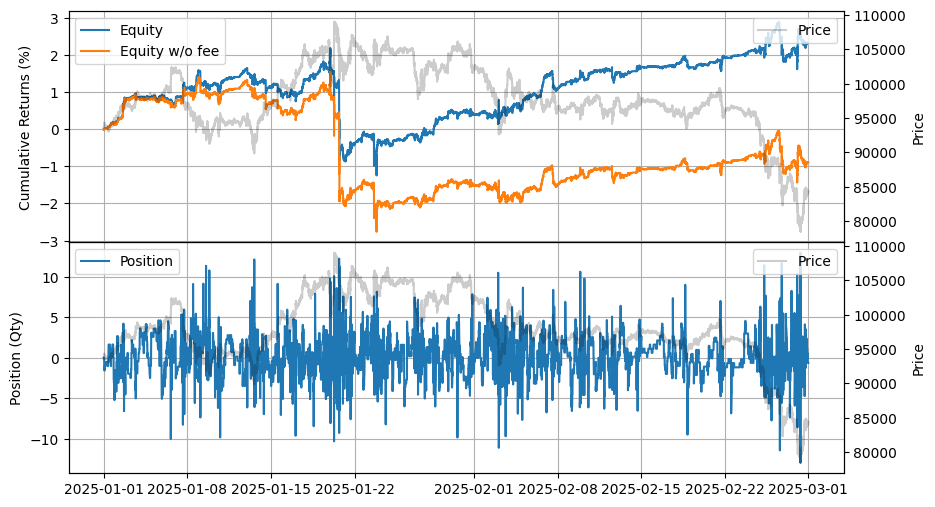

In [31]:
stats.plot()

In [32]:
data = []
date = start_date
while date <= end_date:
    data.append(prepare_px_return(
        f'spot/book_ticker/BTCFDUSD/BTCFDUSD_{date.strftime("%Y%m%d")}.csv.gz',
        f'usdm/book_ticker/BTCUSDT/BTCUSDT_{date.strftime("%Y%m%d")}.csv.gz',
        '100ms',
        3000, # 5-minute
        1500 # 2.5-minute, the average price over a 5-minute window centered around 5 minutes ago
    ).to_numpy())
    date += datetime.timedelta(days=1)
precompute_data = np.concatenate(data, axis=0)

In [33]:
np.savez_compressed("precompute_px_return_BTCFDUSD_5m_202502", data=precompute_data)

In [34]:
precompute_data = np.load('precompute_px_return_BTCFDUSD_5m_2025.npz')['data']

In [35]:
%%time

roi_lb = 50000
roi_ub = 150000

latency_data = []
date = start_date
while date <= end_date:
    latency_data.append('latency/order_latency_{}.npz'.format(date.strftime('%Y%m%d')))
    date += datetime.timedelta(days=1)

data = []
date = start_date
while date <= end_date:
    data.append('data2/btcusdt_{}.npz'.format(date.strftime("%Y%m%d")))
    date += datetime.timedelta(days=1)

asset = (
    BacktestAsset()
        .data(data)
        .initial_snapshot('data2/btcusdt_20241231_eod.npz')
        .linear_asset(1.0) 
        .intp_order_latency(latency_data)
        .power_prob_queue_model(3)
        .no_partial_fill_exchange()
        .trading_value_fee_model(-0.00005, 0.0007)
        .tick_size(0.1)
        .lot_size(0.001)
        .roi_lb(roi_lb)    
        .roi_ub(roi_ub)
)

hbt = ROIVectorMarketDepthBacktest([asset])

recorder = Recorder(1, 60_000_000)

half_spread = 0.0003 # a ratio relative to the fair price
skew = half_spread / 20
interval = 100_000_000 # in nanoseconds. 100ms
order_qty_dollar = 50_000
max_position_dollar = order_qty_dollar * 20
grid_num = 5
grid_interval = 0.0003 # a ratio relative to the fair price

apt_mm(
    hbt,
    recorder.recorder,
    half_spread,
    skew,
    precompute_data,
    interval,
    order_qty_dollar,
    max_position_dollar,
    grid_num,
    grid_interval,
    roi_lb,
    roi_ub
)

hbt.close()

recorder.to_npz('stats/underlying_btcfdusd_return_5m_202502.npz')

CPU times: user 1h 31min 38s, sys: 2min 56s, total: 1h 34min 34s
Wall time: 1h 8s


In [36]:
data = np.load('stats/underlying_btcfdusd_return_5m_202502.npz')['0']
stats = (
    LinearAssetRecord(data)
        .resample('5m')
        .stats(book_size=2_500_000)
)
stats.summary()

start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTurnover,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-01-01 00:00:00,2025-02-28 23:55:00,2.43417,3.17886,0.045953,0.033234,506.877288,10.137426,1.382702,0.000077,1.3039e6


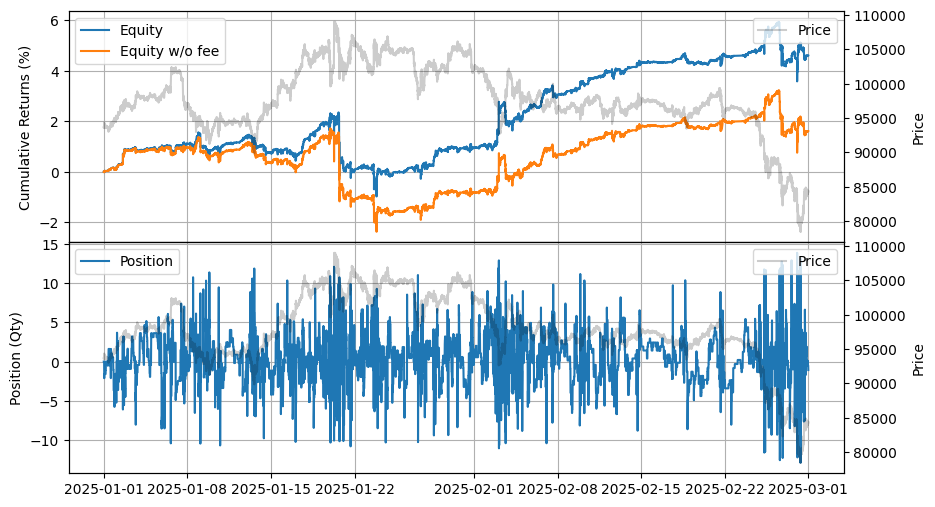

In [37]:
stats.plot()

## Extension to the Multi-Factor Model

### Simple Form: Utilizing Both BTCUSDT and BTCFDUSD Spot Returns
One of the simplest ways to incorporate both BTCUSDT and BTCFDUSD spot returns is by using equal beta, which takes the average of these two values.

In [39]:
precompute_data1 = np.load('precompute_px_return_BTCUSDT_5m_2025.npz')['data']
precompute_data2 = np.load('precompute_px_return_BTCFDUSD_5m_2025.npz')['data']

In [40]:
df1 = pl.DataFrame(precompute_data1).filter(
        pl.col('column_0').is_not_nan()
    ).with_columns(
        pl.col('column_0').cast(pl.Int64),
    )
df2 = pl.DataFrame(precompute_data2).filter(
        pl.col('column_0').is_not_nan()
    ).with_columns(
        pl.col('column_0').cast(pl.Int64),
    )

In [41]:
precompute_data = df1.join(
        df2,
        left_on='column_0',
        right_on='column_0',
        how='full'
    ).sort(
        'column_0'
    ).filter(
        pl.col('column_0').is_not_null()
    ).select(
        local_timestamp = 'column_0',
        btcusdt_spot_return = 'column_1',
        btcfdusd_spot_return = 'column_1_right',
        futures_past_px = 'column_4',
        futures_return = 'column_3'
    ).to_numpy()

In [42]:
@njit
def apt_multi_mm(
    hbt,
    stat,
    half_spread,
    skew,
    beta,
    precompute_data,
    interval,
    order_qty_dollar,
    max_position_dollar,
    grid_num,
    grid_interval_,
    roi_lb,
    roi_ub
):
    asset_no = 0

    tick_size = hbt.depth(0).tick_size
    lot_size = hbt.depth(0).lot_size
    
    roi_lb_tick = int(round(roi_lb / tick_size))
    roi_ub_tick = int(round(roi_ub / tick_size))

    data_i = 0
    spot_return = np.nan
    futures_past_px = np.nan
    
    while hbt.elapse(interval) == 0:
        hbt.clear_inactive_orders(asset_no)
        
        depth = hbt.depth(asset_no)
        position = hbt.position(asset_no)
        orders = hbt.orders(asset_no)

        best_bid = depth.best_bid
        best_ask = depth.best_ask
        
        while data_i < len(precompute_data):
            if precompute_data[data_i, 0] > hbt.current_timestamp:
                if data_i > 0:
                    spot1_return = precompute_data[data_i - 1, 1]
                    spot2_return = precompute_data[data_i - 1, 2]
                    futures_past_px = precompute_data[data_i - 1, 3]
                break
            data_i += 1

        #--------------------------------------------------------
        # Computes bid price and ask price.

        mid_price = (best_bid + best_ask) / 2.0
        order_qty = max(round((order_qty_dollar / mid_price) / lot_size) * lot_size, lot_size)
        
        normalized_position = position / order_qty
        
        relative_bid_depth = half_spread + skew * normalized_position
        relative_ask_depth = half_spread - skew * normalized_position
        alpha = 0
        return_ = beta[0] * spot1_return + beta[1] * spot2_return + alpha
        fair_px = (1 + return_) * futures_past_px

        bid_price = min(fair_px * (1.0 - relative_bid_depth), best_bid)
        ask_price = max(fair_px * (1.0 + relative_ask_depth), best_ask)
        
        bid_price = np.floor(bid_price / tick_size) * tick_size
        ask_price = np.ceil(ask_price / tick_size) * tick_size

        grid_interval = max(tick_size, np.round(grid_interval_ * fair_px / tick_size) * tick_size)
        
        # Aligns the prices to the grid.
        bid_price = np.floor(bid_price / grid_interval) * grid_interval
        ask_price = np.ceil(ask_price / grid_interval) * grid_interval
        
        #--------------------------------------------------------
        # Updates quotes.
        
        # Creates a new grid for buy orders.
        new_bid_orders = Dict.empty(np.uint64, np.float64)
        if position * mid_price < max_position_dollar and np.isfinite(bid_price):
            for i in range(grid_num):
                bid_price_tick = round(bid_price / tick_size)
                
                # order price in tick is used as order id.
                new_bid_orders[uint64(bid_price_tick)] = bid_price
                
                bid_price -= grid_interval

        # Creates a new grid for sell orders.
        new_ask_orders = Dict.empty(np.uint64, np.float64)
        if position * mid_price > -max_position_dollar and np.isfinite(ask_price):
            for i in range(grid_num):
                ask_price_tick = round(ask_price / tick_size)
                
                # order price in tick is used as order id.
                new_ask_orders[uint64(ask_price_tick)] = ask_price

                ask_price += grid_interval
                
        order_values = orders.values();
        while order_values.has_next():
            order = order_values.get()
            # Cancels if a working order is not in the new grid.
            if order.cancellable:
                if (
                    (order.side == BUY and order.order_id not in new_bid_orders)
                    or (order.side == SELL and order.order_id not in new_ask_orders)
                ):
                    hbt.cancel(asset_no, order.order_id, False)
                    
        for order_id, order_price in new_bid_orders.items():
            # Posts a new buy order if there is no working order at the price on the new grid.
            if order_id not in orders:
                hbt.submit_buy_order(asset_no, order_id, order_price, order_qty, GTX, LIMIT, False)
                
        for order_id, order_price in new_ask_orders.items():
            # Posts a new sell order if there is no working order at the price on the new grid.
            if order_id not in orders:
                hbt.submit_sell_order(asset_no, order_id, order_price, order_qty, GTX, LIMIT, False)
        
        # Records the current state for stat calculation.
        stat.record(hbt)

In [43]:
%%time

roi_lb = 50000
roi_ub = 150000

latency_data = []
date = start_date
while date <= end_date:
    latency_data.append('latency/order_latency_{}.npz'.format(date.strftime('%Y%m%d')))
    date += datetime.timedelta(days=1)

data = []
date = start_date
while date <= end_date:
    data.append('data2/btcusdt_{}.npz'.format(date.strftime("%Y%m%d")))
    date += datetime.timedelta(days=1)

asset = (
    BacktestAsset()
        .data(data)
        .initial_snapshot('data2/btcusdt_20241231_eod.npz')
        .linear_asset(1.0) 
        .intp_order_latency(latency_data)
        .power_prob_queue_model(3)
        .no_partial_fill_exchange()
        .trading_value_fee_model(-0.00005, 0.0007)
        .tick_size(0.1)
        .lot_size(0.001)
        .roi_lb(roi_lb)    
        .roi_ub(roi_ub)
)

hbt = ROIVectorMarketDepthBacktest([asset])

recorder = Recorder(1, 60_000_000)

half_spread = 0.0003 # a ratio relative to the fair price
skew = half_spread / 20
interval = 100_000_000 # in nanoseconds. 100ms
order_qty_dollar = 50_000
max_position_dollar = order_qty_dollar * 20
grid_num = 5
grid_interval = 0.0003 # a ratio relative to the fair price
beta = np.asarray([0.5, 0.5])

apt_multi_mm(
    hbt,
    recorder.recorder,
    half_spread,
    skew,
    beta,
    precompute_data,
    interval,
    order_qty_dollar,
    max_position_dollar,
    grid_num,
    grid_interval,
    roi_lb,
    roi_ub
)

hbt.close()

recorder.to_npz('stats/underlying_btcspot_return_5m_2025.npz')

CPU times: user 1h 33min 2s, sys: 3min, total: 1h 36min 2s
Wall time: 1h 1min 31s


In [44]:
data = np.load('stats/underlying_btcspot_return_5m_2025.npz')['0']
stats = (
    LinearAssetRecord(data)
        .resample('5m')
        .stats(book_size=2_500_000)
)
stats.summary()

start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTurnover,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-01-01 00:00:00,2025-02-28 23:55:00,2.266827,2.920951,0.038573,0.03424,489.961038,9.799065,1.126546,0.000067,1.3342e6


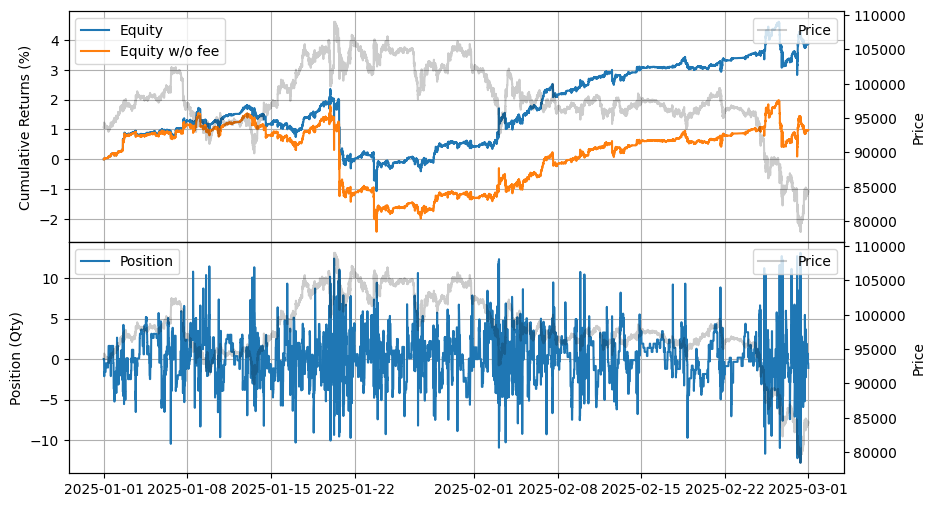

In [45]:
stats.plot()

### MLR: Utilizing Both BTCUSDT and BTCFDUSD Spot Returns
Since these two variables are highly correlated, proper handling is necessary. One approach is the residual method, but other techniques, such as PCA, can also be used to eliminate correlation. Additionally, when applying Multiple Linear Regression, you may need to constrain beta values within a specific range, such as ensuring they remain positive. In such cases, more advanced techniques can be utilized.

In [47]:
ts = datetime.datetime(2025, 2, 1, tzinfo=datetime.timezone.utc).timestamp() * 1_000_000_000
train_end = np.min(np.where(df['local_timestamp'] > ts))

In [48]:
precompute_data = df.filter(
        pl.col('btcusdt_spot_return').is_not_nan()
        & pl.col('btcfdusd_spot_return').is_not_nan()
        & pl.col('futures_return').is_not_nan()
    ).to_numpy()

Given the assumption that the deviation in futures returns mean-reverts to the spot return, the target is set as the spot return.

In [49]:
# Regresses BTCUSDT spot returns on BTCFDUSD spot returns to get residuals.
# x1 = BTCFDUSD spot returns
# x2 = BTCUSDT spot returns
x1 = sm.add_constant(precompute_data[:train_end, 2])
model_x2 = sm.OLS(precompute_data[:train_end, 1], x1).fit()
x2_residual = precompute_data[:train_end, 2] - model_x2.predict(x1)

# Regresses BTCUSDT futures returns on BTCFDUSD spot returns and the residual of BTCUSDT spot returns.
X = sm.add_constant(np.column_stack((precompute_data[:train_end, 2], x2_residual)))
model = sm.OLS(precompute_data[:train_end, 4], X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 9.707e+09
Date:                Sun, 09 Mar 2025   Prob (F-statistic):               0.00
Time:                        10:52:52   Log-Likelihood:             2.1219e+08
No. Observations:            26644398   AIC:                        -4.244e+08
Df Residuals:                26644396   BIC:                        -4.244e+08
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.297e-07   1.63e-08    -14.084      0.0

In [50]:
%%time

roi_lb = 50000
roi_ub = 150000

latency_data = []
date = start_date
while date <= end_date:
    latency_data.append('latency/order_latency_{}.npz'.format(date.strftime('%Y%m%d')))
    date += datetime.timedelta(days=1)

data = []
date = start_date
while date <= end_date:
    data.append('data2/btcusdt_{}.npz'.format(date.strftime("%Y%m%d")))
    date += datetime.timedelta(days=1)

asset = (
    BacktestAsset()
        .data(data)
        .initial_snapshot('data2/btcusdt_20241231_eod.npz')
        .linear_asset(1.0) 
        .intp_order_latency(latency_data)
        .power_prob_queue_model(3)
        .no_partial_fill_exchange()
        .trading_value_fee_model(-0.00005, 0.0007)
        .tick_size(0.1)
        .lot_size(0.001)
        .roi_lb(roi_lb)    
        .roi_ub(roi_ub)
)

hbt = ROIVectorMarketDepthBacktest([asset])

recorder = Recorder(1, 60_000_000)

half_spread = 0.0003 # a ratio relative to the fair price
skew = half_spread / 20
interval = 100_000_000 # in nanoseconds. 100ms
order_qty_dollar = 50_000
max_position_dollar = order_qty_dollar * 20
grid_num = 5
grid_interval = 0.0003 # a ratio relative to the fair price
beta = np.asarray([-0.0117, 1.0164])

apt_multi_mm(
    hbt,
    recorder.recorder,
    half_spread,
    skew,
    beta,
    precompute_data,
    interval,
    order_qty_dollar,
    max_position_dollar,
    grid_num,
    grid_interval,
    roi_lb,
    roi_ub
)

hbt.close()

recorder.to_npz('stats/underlying_btcspot2_return_5m_2025.npz')

CPU times: user 1h 29min 31s, sys: 3min 11s, total: 1h 32min 42s
Wall time: 58min 22s


In [51]:
data = np.load('stats/underlying_btcspot2_return_5m_2025.npz')['0']
stats = (
    LinearAssetRecord(data)
        .resample('5m')
        .stats(book_size=2_500_000)
)
stats.summary()

start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTurnover,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2025-01-01 00:00:00,2025-02-28 23:55:00,3.066696,4.017417,0.057006,0.030539,533.455123,10.66894,1.86669,0.000091,1.3075e6


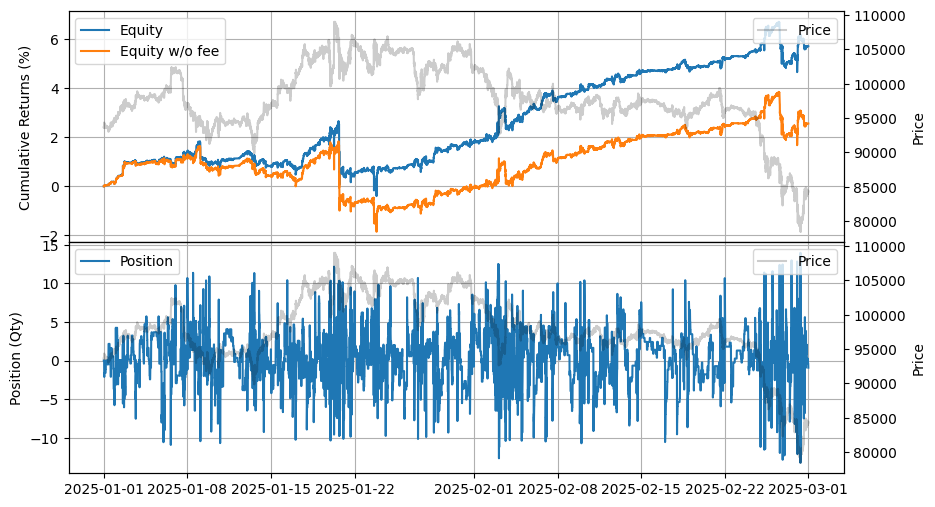

In [52]:
stats.plot()

## A Comprehensive Framework for Pricing Models
Let's explore a more generalized approach to asset pricing from a conceptual standpoint.

### Core Market Drivers (Primary Price Movement)
The first component represents price movement driven by core market instruments — typically spot and futures markets across major venues. It can be expressed as:

```
Return_BTC = β00 * BTCUSDT_spot
           + β01 * BTCFDUSD_spot
           + β02 * BTCUSDT_futures_on_exchange1
           + β03 * BTCUSD_inverse_perpetual1
           + β04 * BTCUSD_CME_futures
           + β05 * BTC_ETF1
           + ...
```
This model doesn’t require all components. You can identify the most influential inputs using statistical methods (e.g., regression, PCA, or Granger causality), or by analyzing market depth, trading volume, and lead-lag relationships between exchanges. You can also see the importance of considering the Trad-Fi market — including CME futures, Bitcoin ETFs, and equity markets — by comparing weekday returns, which highlight a different return profile on weekends (typically better).

### Broader Market Influence (Cross-Asset Correlation)
Bitcoin’s price can also be influenced by the movement of other major cryptocurrencies — similar to how components interact with an index:

```
Return_CrossAsset = β10 * ETHUSDT_futures
                  + β11 * SOLUSDT_futures
                  + ...
```
You may also use spot markets, but it’s important to select markets with high liquidity and trading volume, as they are more likely to drive broader price movements.

### Microstructure Signals & Alpha Factors
Short-term price forecasts can benefit from market microstructure data and proprietary alpha signals. These might include:

```
Return_Alpha = β20 * OrderBookImbalance1
             + β21 * OrderBookImbalance2
             + β22 * FundingRateAlpha
             + β23 * OpenInterestAlpha
             + ...
             + β2n * CustomAlpha_n
```
These signals are especially valuable for short-horizon trading, such as high-frequency or latency-sensitive strategies.

### Combined Pricing Model
All components can be integrated into a single predictive return model:

```
Forecast_Return = β0 * Return_Self
                + Return_BTC
                + Return_CrossAsset
                + Return_Alpha
```
Return_BTC and Return_CrossAsset reflect structural or market-level influences and Return_Alpha represents short-term, predictive signals based on microstructure or custom models. In addition, defining fair value price is crucial, as it shapes your trading setup. A straight defintion is to forecast future returns (e.g., 10s, 30s, 1min, 5min), depending on the trading horizon. The regression target should then be this fair value price.

### Exchange-Specific Application
The effectiveness of this model may depend on your forecasting horizon:

For medium-term forecasts (e.g., 1–5 minutes), this model can generalize across major venues such as Binance, Bybit, OKX, and Hyperliquid.

For very short-term trading (e.g., sub-second to a few seconds), you need to account for exchange-specific dynamics such as latency, liquidity, and order flow patterns.

For example, since Binance Futures has the highest trading volume, its price movements often lead the market. Other exchanges may lag behind.

The simplest cross-exchange model might look like this:

```
Return_Bybit ≈ Return_Binance
```

This setup is useful for cross-exchange arbitrage or liquidity-driven strategies, where you exploit short-term dislocations between platforms.

More examples incorporating additional factors beyond BTC returns and cross-exchange cases such as described in https://hangukquant.github.io/scripts/market_making, will be added.